# 1. Business Understanding
**Objective:** Develop a robust machine learning model that can accurately classify handwritten digits (0-9), despite variations in handwriting styles.

**Challenges:** High intra-class variance due to different writing styles, potential noise in images, and class imbalance.

**Success Criteria:** Model performance will be evaluated based on accuracy, precision, recall, and robustness to difficult cases.

# 2. Data Understanding
**Dataset:** The MNIST dataset, containing 70,000 gray scale images (60,000 for training, 10,000 for testing), each sized 28x28 pixels.
## Feature Considerations:
- Presence of closed loops (e.g., 0, 6, 8)
- Stroke thickness variation
- Aspect ratios and curvatures (e.g., distinguishing 1 from 7)
- Edge detection and texture information

# 3. Data Preparation

In [159]:
import numpy as np
dataArrays = np.load("Imports/mnist_combined.npz")

dataImages = dataArrays['images']
dataLables = dataArrays['labels']

# we should have 70K images with an with and height of 28 pixels.
print ("loaded dataset from file. Shape of Images data set:", dataImages.shape)

loaded dataset from file. Shape of Images data set: (70000, 28, 28)



## Preprocessing Steps:

### Cleaning the Images
- Normalize pixel values (0-255 → 0-1)
- Apply data augmentation (rotation, shifting, noise addition) to improve generalization


#### Explanation
Each pixel in the image is not in a binary state, they are on a gray scale which value can range from 0 to 255. So we first normalize every pixel to be a value of 0 or 1, which helps clean up the images a little.

The result of this can cause the image is not most likely very noisy. So a GaussianBlur is applied to "smooths" out the image high frequency components and acts as a low-pass filter, with the goal of preserving the edges and boundaries of the number inside the image [1]. Or to but it another way: After we have applied the GaussianBlur, the hope is that there is only one connected set of pixels that make up the number inside the image, an there should be no orphans or single islands else where.

Finally, we can use Binarization [2] to simplify features extraction later by highlighting digit strokes clearly. 

In [160]:
import cv2

def Preprocess_image(img):
    "Preprocess image: Normalize, remove noise, and binarize."
    img = img / 255.0  # Normalize pixel values to range [0,1] for consistency across models.
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian blur to reduce small noise artifacts. (3,3): K-size need to be tested. IMPORTANT!!! keep these numbers odd and grater than or equal to 0
    ret, img = cv2.threshold(img, 0.5, 1.0, cv2.THRESH_BINARY)  # Convert to binary format to simplify features. [2]
    print(ret)
    return img

### Extraction Steps
- Edge direction for stroke shape vector creation (Histogram of Oriented Gradients [4] [5] [6])
- Edge filtering using Sobel filter 
- Image Zoning for pixel shape similarity identification comparison
- Principal Component Analysis (PCA) for dimensionality reduction
- Convert images into numerical feature vectors for models that require structured input

#### Explanation

In [161]:
from skimage.feature import hog
# Extracts Histogram of Oriented Gradients from a given image.
def Histogram_of_Oriented_Gradients(img):
    # Size in pixels for each cell block
    pixelsPerCell = (4,4)
    # Cells per block to look at
    cellsPerBlock = (2,2) 
    # Return the data as a vector
    featureVector = True

    # We are telling hog that each cell is 4 by 4 per cell,
    # and we want hog to normalize an area of 2 by 2 cell blocks.
    # This totals 4x2 by 4x2 :> 16 total pixels looked at to calculate the
    # vector. This helps reduce noise and "smooth" out the vector a little.

    # TODO:: look into this a little more as I feel that I am not 100% sure I fully understand
    ## this step.
    return hog(img, pixels_per_cell=pixelsPerCell, cells_per_block=cellsPerBlock, feature_vector=featureVector)


In [162]:
from skimage.filters import sobel
def Sobel_Edge_Detection(img):
    # enhance edge contrast, making digit contours clearer for feature extraction
    return sobel(img).flatten()

In [163]:
def Extract_features(img):
    # Use HOG to identify differences in digits based on stroke patterns.
    #TODO:: Look into this more for a better understanding, at the moment
    ## I am just doing this because it is recommended by the guide.
    hog_features = Histogram_of_Oriented_Gradients(img)

    # Edge detection using sobel filter
    edge_features = Sobel_Edge_Detection(img)

    # Split image into 4 by 4 regions and calculate pixel densities
    zones = []
    for i in range(0,28, 7):
        for j in range (0, 28, 7):
            zone = img[i:i+7, j:j+7]
            zones.append(np.sum(zone))

    features = np.hstack([hog_features, edge_features])
    return features

### Explanation of above

### Running the code

0.5


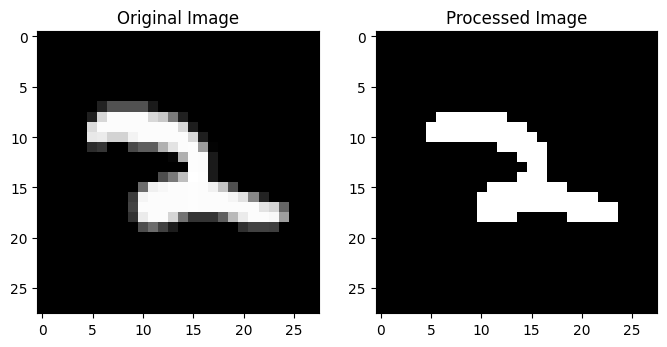

Extracted feature vector shape: [0. 0. 0. ... 0. 0. 0.]


In [ ]:
import matplotlib.pyplot as plt

image_sample = np.random.randint(0,len(dataImages)) # Testing: Select a random image
image_original = dataImages[image_sample].reshape(28,28)

image_processed = Preprocess_image(image_original)

# Extract features, pass in the "Cleaned" processed image.
features = Extract_features(image_processed)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(image_processed, cmap='gray')
plt.title("Processed Image")
plt.show()

print("Extracted feature vector shape:", features.shape) # Look into why the feature vector shape is always 2080?

# 4. Modeling
**Baseline Model:** Logistic Regression or k-NN for quick benchmarking.

## ML Approaches:
- Support Vector Machine (SVM) with HOG features
- Random Forest or XGBoost on extracted features

# 5. Evaluation
**Metrics:**
- Accuracy (primary metric)
- Confusion Matrix to analyze misclassifications
- Precision, Recall, F1-score for class-specific performance
- Robustness Testing:
- Evaluate on distorted and rotated images
- Assess performance on ambiguous samples

# 6. References
## Image pre-processing
[1]“Gaussian Blur - an overview | ScienceDirect Topics,” www.sciencedirect.com. https://www.sciencedirect.com/topics/engineering/gaussian-blur

[2]“Python | Thresholding techniques using OpenCV | Set-1 (Simple Thresholding) - GeeksforGeeks,” GeeksforGeeks, May 06, 2019. https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-1-simple-thresholding/
‌

[3]F. Daghero, D. J. Pagliari, and M. Poncino, “Energy-efficient deep learning inference on edge devices,” Advances in Computers, pp. 247–301, 2021, doi: https://doi.org/10.1016/bs.adcom.2020.07.002.

## Histogram of Gradients
[4]UCF CRCV, “Lecture 9.3: Features [Histogram of Gradients] [HOG],” YouTube, Jul. 26, 2023. https://www.youtube.com/watch?v=92-NaIdIrEs (accessed Mar. 15, 2025).
‌‌

[5]R. Manavalan, “Automatic identification of diseases in grains crops through computational approaches: A review,” Computers and Electronics in Agriculture, vol. 178, p. 105802, Nov. 2020, doi: https://doi.org/10.1016/j.compag.2020.105802.


[6]Skillcate AI, “HOG Intuition | Simple Explanation | Feature Descriptor & Engineering,” YouTube, Jun. 13, 2021. https://www.youtube.com/watch?v=5nZGnYPyKLU (accessed Mar. 15, 2025).

## Sobel Filter
[7]“Sobel Filter - an overview | ScienceDirect Topics,” www.sciencedirect.com. https://www.sciencedirect.com/topics/computer-science/sobel-filter
‌
‌
‌